# **Tarea 2. Ezau Faridh Torres Torres**

**INSTRUCCIONES**: Considere el valor histórico (por hora o al menos dic) de cripto-monedas (al menos 7 series, incluyendo el bitcoin) obtenga N series de al menos una longitud de T = 100. Luego entrene un modelo para dadas las series S[:T-t] prediga la parte final de cada serie S[T-t:]. Un valor típico es t=5. Los datos descárgelos usando la librería yahoo-finance. Implementar un modelo Seq2seq con atención, usando refuerzo del profesor (teacher forcing).

Se usaron $300$ épocas, un batch size de $32$, $1000$ neuronas en las capas LSTM (espacio latente). Debido a la diferencia de magnitudes entre los costos de las monedas, se decidió usar la normalización **MinMaxScaler** de **sklearn**.

**NOTA:** Cada vez que este corra la sección de Preparación de Datos, la base de datos se actualizará ya que se inicializa con las últimos 100 horas de los valores de las criptomonedas (al momento).

# **1.- Librerías**

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate

# **2.- Preparación de Datos**

## **2.1.- Descarga de datos**

Se descargan las listas de los datos históricos de las 7 criptomonedas. Dado que se utilizan $100$ horas en todo el proceso, basta tomar los datos históricos de los últimos días. En particular, se descargan los datos del último mes. La categoría de interés es el precio de cierre de cada criptomoneda, se construye un DataFrame con los precios de cierre de todas las criptomonedas. Después, se eliminan filas con valores nulos y se seleccionan los últimos 101 puntos temporales para trabajar.

In [2]:
# Definición de las criptomonedas a analizar
cryptos = ['BTC-USD','ETH-USD','DOGE-USD','ADA-USD','LTC-USD','SOL-USD','DOT-USD']
# Los nombres de estas monedas son:
nombres_columnas = ['Bitcoin','Ethereum','Dogecoin','Cardano','Litecoin','Solana','Polkadot']

# Descargar datos
data = {}
for crypto in cryptos:
    data[crypto] = yf.download(tickers=crypto, period='1mo', interval='1h')

# Se selecciona el valor de 'Close' para cada criptomoneda
df = pd.DataFrame({crypto: data[crypto]['Close'] for crypto in cryptos})
df = df.dropna()  # Eliminar filas con valores nulos
T = 101
df = df.iloc[-T:] # Seleccionar los últimos T puntos 
t = 5             # Número de pasos en el tiempo

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
df

,BTC-USD,ETH-USD,DOGE-USD,ADA-USD,LTC-USD,SOL-USD,DOT-USD
Datetime,,,,,,,
2024-09-13 15:00:00+00:00,59621.039062,2405.925781,0.108033,0.363606,64.926949,136.528564,4.413046
2024-09-13 16:00:00+00:00,59476.136719,2407.518066,0.107072,0.360846,64.814842,136.580704,4.431979
2024-09-13 17:00:00+00:00,59604.531250,2411.465576,0.107074,0.362268,64.473793,136.696869,4.445594
2024-09-13 18:00:00+00:00,59752.820312,2420.875244,0.107092,0.361057,64.763016,137.843460,4.458931
2024-09-13 19:00:00+00:00,59700.980469,2414.659912,0.106381,0.359093,64.506149,137.970367,4.428148
...,...,...,...,...,...,...,...
2024-09-17 15:00:00+00:00,61137.273438,2384.283203,0.102257,0.341553,63.824806,134.717957,4.257386
2024-09-17 16:00:00+00:00,60929.800781,2370.738525,0.101427,0.336783,63.549152,132.629761,4.201509
2024-09-17 17:00:00+00:00,60930.546875,2366.480225,0.101824,0.336631,63.559002,133.230652,4.197951


## **2.2.- Escalamiento de Datos**

Se usa el **MinMaxScaler** de **sklearn** debido a la diferencia de magnitudes entre los costos de las monedas. Se intentaron usar diferentes tipos de escalamiento para sectores de las criptomonedas, pero el usar **MinMaxScaler** funcinó bastante bien.

Posteriormente, se separaron los datos en los primeras 95 observaciones de la serie de tiempo y las últimas 5. Y se agregó una dimensión adicional para el manejo de datos.

In [4]:
# Escalar los datos
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Crear datos de entrada (S[:T-t]) y salida (S[T-t:])
X_scaled = df_scaled.iloc[:T-t].values  # Datos de entrada (T-t=96 puntos)
Y_scaled = df_scaled.iloc[T-t:].values  # Datos de salida (últimos t=5 puntos)

# Expandir para que sea de 3D y para ser usados en LSTM
X_scaled = np.expand_dims(X_scaled, axis=0) 
Y_scaled = np.expand_dims(Y_scaled, axis=0)

# **3.- Modelo**

Se propuso usar $1000$ neuronas en las capas LSTM.

In [5]:
# Parámetros del modelo
neuronas_LSTM = 1000           # Dimensión del espacio latente (número de neuronas en la capa LSTM)
tiempos = T - t                # Longitud de la entrada (número de puntos en la serie temporal, 95)
n_features = X_scaled.shape[2] # Número de criptomonedas (características, 7)

## **3.1.- Encoder**

Usa una capa LSTM para procesar las secuencias de entrada (X_scaled). La entrada del modelo es el número de puntos en la serie de tiempo (95) para cada una de las criptomonedas (7) y la LSTM devuelve dos estados (state_h y state_c) que se pasarán al decodificador.

In [6]:
# Codificador (Encoder)
encoder_inputs = Input(shape=(tiempos, n_features))                          # Entrada del codificador
encoder_lstm = LSTM(neuronas_LSTM, return_sequences=True, return_state=True) # Capa LSTM
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)             # Salida del codificador
encoder_states = [state_h, state_c]                                          # Estados del codificador

## **3.2.- Decoder**

Recibe los datos de salida (Y_scaled) y los estados del encoder como inicialización y también es una capa LSTM que procesa la secuencia de salida.

In [7]:
# Decodificador (Decoder)
decoder_inputs = Input(shape=(t, n_features))                                      # Entrada del decodificador
decoder_lstm = LSTM(neuronas_LSTM, return_sequences=True, return_state=True)       # Capa LSTM
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states) # Salida del decodificador

## **3.3.- Atención y capa de salida**

Implementa una capa de atención (Attention) que calcula la relevancia de las salidas del encoder para las entradas del decodificador. Después de concatenar la salida del decodificador con la atención, se pasa por una capa densa con activación lineal para predecir las secuencias futuras.

In [8]:
# Atención
attention = Attention(score_mode="dot")                         # Capa de atención
vector_contexto = attention([decoder_outputs, encoder_outputs]) # Salida de la atención

# Se concatena la salida del decodificador con la atención
decoder_context = Concatenate(axis=-1)([decoder_outputs, vector_contexto]) 

# Capa densa de salida
decoder_dense = Dense(n_features, activation = 'linear')  # Capa de salida
decoder_outputs = decoder_dense(decoder_context)          # Salida de la capa de salida

## **3.4.- Summary**

In [9]:
# Definir el modelo Seq2Seq con atención
Seq2Seq = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compilar el modelo
Seq2Seq.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', 'mae'])
# Se espera que se tenga un accuracy de 1 debido al teacher forcing, por esto se puede ignorar
# el accuracy en la compilación del modelo.

# Resumen del modelo
Seq2Seq.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5, 7)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 96,       │  4,032,000 │ input_layer[0][0] │
│                     │ 1000), (None,     │            │                   │
│                     │ 1000), (None,     │            │                   │
│                     │ 1000)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 5, 1000), │  4,032,000 │ input_layer_1[0]… │
│                     │ (None, 1000),     │            │ lstm[0][1],       │
│                     │ (None, 1000)]     │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 5, 1000)   │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5, 2000)   │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5, 7)      │     14,007 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,078,007 (30.82 MB)

 Trainable params: 8,078,007 (30.82 MB)

 Non-trainable params: 0 (0.00 B)

## **4.- Entrenamiento**

Se usa Teacher Forcing: Se alimentan los valores reales desplazados como entradas al decodificador para facilitar el entrenamiento.

In [10]:
# Entrenamiento con Teacher Forcing
decoder_input_data = np.zeros_like(Y_scaled)       # Inicializamos con ceros
decoder_input_data[:, 1:, :] = Y_scaled[:, :-1, :] # El decoder recibe el target desplazado como entrada

# Entrenar el modelo
history = Seq2Seq.fit([X_scaled, decoder_input_data], Y_scaled, batch_size=32, epochs=300)

Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step - accuracy: 0.0000e+00 - loss: 0.2141 - mae: 0.3975
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 1.0000 - loss: 0.0076 - mae: 0.0660
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 1.0000 - loss: 0.1130 - mae: 0.2512
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 1.0000 - loss: 0.0433 - mae: 0.1715
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 1.0000 - loss: 0.0620 - mae: 0.2092
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 1.0000 - loss: 0.0520 - mae: 0.1821
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 1.0000 - loss: 0.0322 - mae: 0.1268
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 1.0000 - loss: 0.0232 - mae: 0.1237
Epoch 9/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 1.0000 - loss: 0.0245 - mae: 0.1256
Epoch 10/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 1.0000 - loss: 0.0099 - mae: 0.0724
Epoch

## **5.- Inferencia**

In [11]:
# Realizar predicciones usando el modelo entrenado
predicciones_scaled = Seq2Seq.predict([X_scaled, decoder_input_data])

# Desescalar las predicciones y los valores reales para comparar
predicciones = scaler.inverse_transform(predicciones_scaled[0])
Y_real = scaler.inverse_transform(Y_scaled[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


## **6.- Resultados**

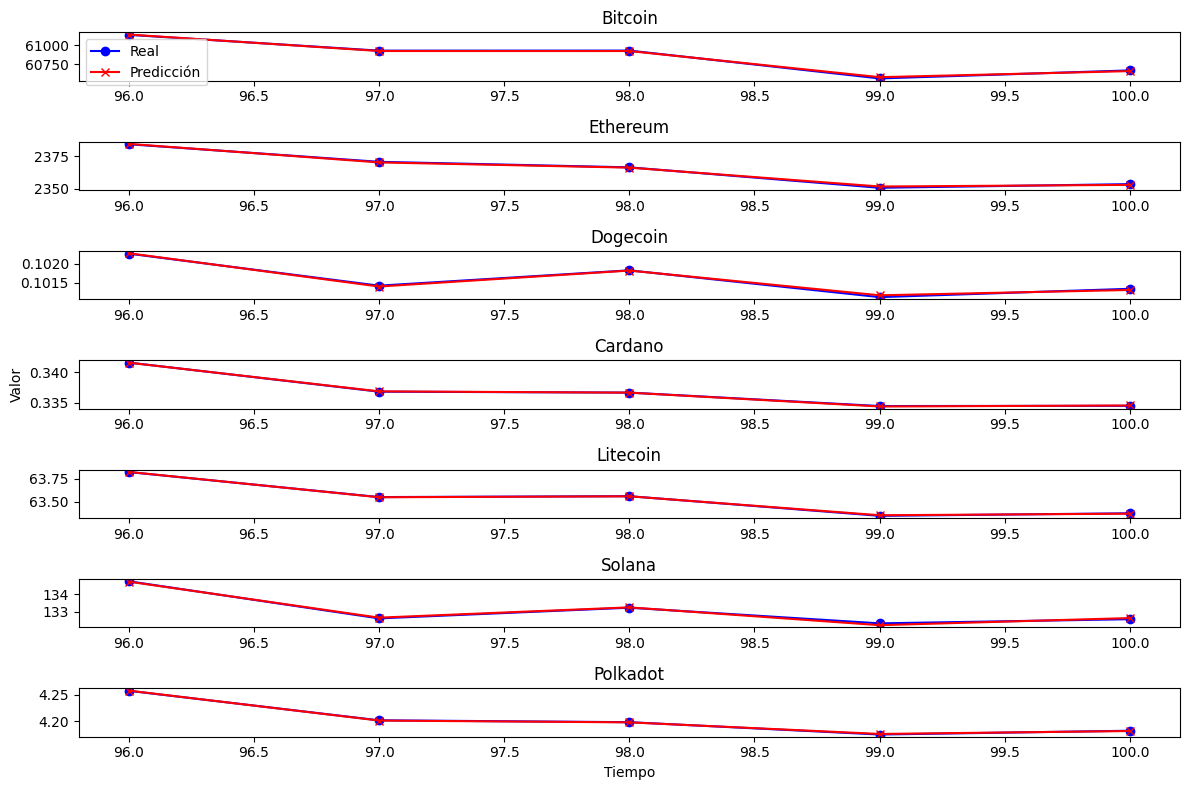

In [12]:
# Graficar los resultados
plt.figure(figsize=(12, 8))

n_cryp = Y_scaled.shape[2]  # Número de criptomonedas
for i in range(n_cryp):
    plt.subplot(n_cryp, 1, i + 1)
    plt.plot(range(T-t, T), Y_real[:, i], label='Real', marker='o', c='blue')
    plt.plot(range(T-t, T), predicciones[:, i], label='Predicción', marker='x', c='red')
    plt.title(nombres_columnas[i])
    if i == n_cryp - 1:
        plt.xlabel('Tiempo')
    if i == 0:
        plt.legend()
    if i == 3:
        plt.ylabel('Valor')
plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_real, predicciones)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 12.316701010363
